<center><h1>WGAN Model</h1></center>

#### Model Summary

##### 1. Base Model

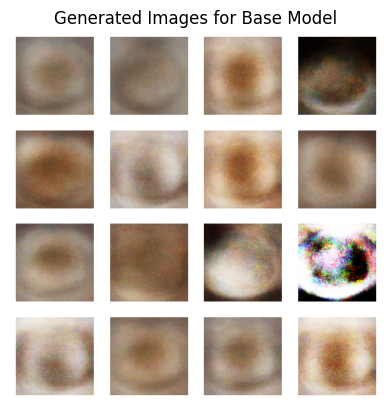

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "./Generated_Images/BaseModel.png"

img = mpimg.imread(image_path)
plt.imshow(img)
plt.title('Generated Images for Base Model')
plt.axis('off')  
plt.show()


##### 2. Model Tuning 1

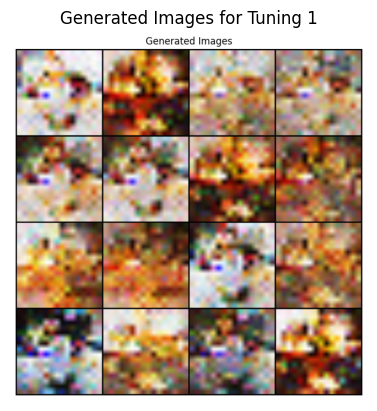

In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "./Generated_Images/Tuning1.png"

img = mpimg.imread(image_path)
plt.imshow(img)
plt.title('Generated Images for Tuning 1')
plt.axis('off')  
plt.show()


In [100]:
# File path
file_path = "metrics.txt"

# Read the file line by line
with open(file_path, "r") as file:
    lines = file.readlines()

# Print the content
for line in lines:
    print(line.strip())  # Remove any leading/trailing whitespace


FID Score Base Model: 369.6523
Inception Score Base Model: 2.1254 ± 0.0471
FID Score for Tuning 1: 440.4061
Inception Score for Tuning 1: 1.4904 ± 0.0400


## MECE
| Name               | Task Done      |
|-----------------------|----------------------------|
| Arshia | Model Building and Evaluation of Base model and Tuning 1 of WGAN |
| Baldeep | Model Building and Evaluation of Tuning 2 and Tuning 3 of WGAN |
| Shubham | Deployment |
| Sameer | Deployment |
| Aman | DCGAN | 
| Ramandeep | DCGAN | 
| Abhishek | VAE | 
| Ram Krishna | VAE |
| Palash | cGAN |
| Govind | cGAN |


#### Importing Libraries

In [65]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
import random
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision.models import inception_v3
from torcheval.metrics import FrechetInceptionDistance
from torchvision.transforms import functional as F

In [32]:
# !pip install torcheval

In [2]:
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True
CUDA Version: 12.1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
photos_df = pd.read_json(r'C:\Users\arshi\Desktop\AI & DS\Term3\DL\Assignments\Graded4\photos.json', lines=True)

In [4]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [5]:
photos_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [6]:
count_type = []
for i in photos_df['label'].unique():
    count_type.append(photos_df['label'].tolist().count(i))
    print(f"{i} class - {photos_df['label'].tolist().count(i)} images")

inside class - 56031 images
outside class - 18569 images
drink class - 15670 images
food class - 108152 images
menu class - 1678 images


<BarContainer object of 5 artists>

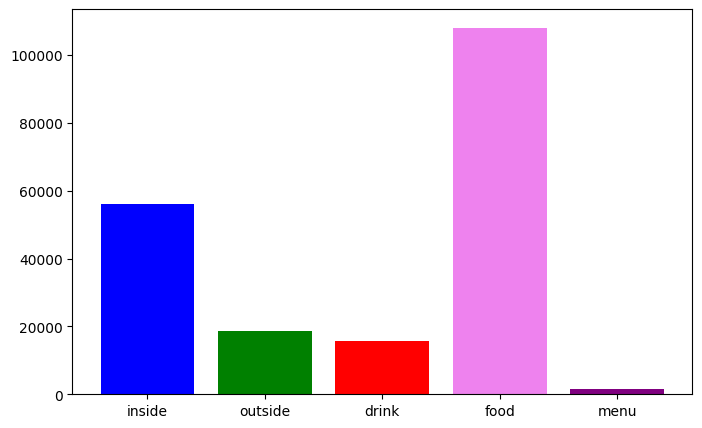

In [7]:
plt.figure(figsize=(8, 5))
plt.bar(photos_df['label'].unique(), count_type, color=['blue', 'green', 'red', 'violet', 'purple'])

In [8]:
# Dataset Class
class YelpDataset(Dataset):
    def __init__(self, image_folder, json_file, label_filter, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.label_filter = label_filter
        self.image_files = []

        with open(json_file, 'r') as f:
            for line in f:
                try:
                    entry = json.loads(line.strip())
                    if entry.get('label') == self.label_filter:
                        image_filename = entry['photo_id'] + '.jpg'
                        image_path = os.path.join(image_folder, image_filename)
                        if os.path.isfile(image_path):
                            try:
                                with Image.open(image_path) as img:
                                    img.verify()
                                self.image_files.append(image_filename)
                            except Exception as e:
                                print(f"Skipping corrupted image {image_filename}: {str(e)}")
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON line: {line.strip()} -> {str(e)}")

        print(f"Found {len(self.image_files)} valid images with label '{self.label_filter}'")
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        while True:
            try:
                img_path = os.path.join(self.image_folder, self.image_files[idx])
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image
            except Exception as e:
                print(f"Error loading image {self.image_files[idx]}: {str(e)}")
                idx = (idx + 1) % len(self.image_files)

In [9]:
photos = r'C:\Users\arshi\Desktop\AI & DS\Term3\DL\Assignments\Graded4\photos'
metadata = r'C:\Users\arshi\Desktop\AI & DS\Term3\DL\Assignments\Graded4\photos.json'
label_filter = "food"

In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

In [11]:
dataset = YelpDataset(image_folder=photos, json_file=metadata, label_filter=label_filter, transform=transform)

Skipping corrupted image ydm3g1wUWSxJnMPgHk2JhQ.jpg: cannot identify image file 'C:\\Users\\arshi\\Desktop\\AI & DS\\Term3\\DL\\Assignments\\Graded4\\photos\\ydm3g1wUWSxJnMPgHk2JhQ.jpg'
Skipping corrupted image JGpfPj8VEvnq1B-Xqr3w-A.jpg: cannot identify image file 'C:\\Users\\arshi\\Desktop\\AI & DS\\Term3\\DL\\Assignments\\Graded4\\photos\\JGpfPj8VEvnq1B-Xqr3w-A.jpg'
Skipping corrupted image bf3ymV0YgP7B6rEoriaU2w.jpg: cannot identify image file 'C:\\Users\\arshi\\Desktop\\AI & DS\\Term3\\DL\\Assignments\\Graded4\\photos\\bf3ymV0YgP7B6rEoriaU2w.jpg'
Skipping corrupted image juDNZOOnkgG3QINFrulsAg.jpg: cannot identify image file 'C:\\Users\\arshi\\Desktop\\AI & DS\\Term3\\DL\\Assignments\\Graded4\\photos\\juDNZOOnkgG3QINFrulsAg.jpg'
Skipping corrupted image 9X4YPM8nYFjf7hY8xUdc6Q.jpg: cannot identify image file 'C:\\Users\\arshi\\Desktop\\AI & DS\\Term3\\DL\\Assignments\\Graded4\\photos\\9X4YPM8nYFjf7hY8xUdc6Q.jpg'
Skipping corrupted image N6hL8FQ84A2DznF2S2Lp7g.jpg: cannot identify i

## Base Model

In [14]:
subset_indices = random.sample(range(len(dataset)), min(7000, len(dataset))) 
subset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=64, shuffle=True)

In [16]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 128 * 128 * 3),  # Output size for 128x128x3 image
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 128, 128)  # Reshape to 128x128x3
        return img

In [17]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128 * 128 * 3, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten 128x128x3 images
        validity = self.model(img_flat)
        return validity

In [18]:
latent_dim = 100
generator_base = Generator(latent_dim).cuda()
discriminator_base = Discriminator().cuda()

In [20]:
optimizer_G = optim.RMSprop(generator_base.parameters(), lr=0.0002)
optimizer_D = optim.RMSprop(discriminator_base.parameters(), lr=0.0002)

In [21]:
# Training Loop
n_epochs = 50
n_critic = 5

In [23]:
for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.cuda()

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).cuda()
        fake_imgs = generator_base(z).detach()
        loss_D = -torch.mean(discriminator_base(real_imgs)) + torch.mean(discriminator_base(fake_imgs))
        loss_D.backward()
        optimizer_D.step()

        # Clip discriminator weights
        for p in discriminator_base.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Train Generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            gen_imgs = generator_base(z)
            loss_G = -torch.mean(discriminator_base(gen_imgs))
            loss_G.backward()
            optimizer_G.step()

    print(f"[Epoch {epoch + 1}/{n_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")


[Epoch 1/50] Loss_D: -477.4080 Loss_G: -34.0941
[Epoch 2/50] Loss_D: 5.7556 Loss_G: -22.5922
[Epoch 3/50] Loss_D: 13.2684 Loss_G: 751.8094
[Epoch 4/50] Loss_D: -168.6426 Loss_G: 600.5760
[Epoch 5/50] Loss_D: -43.3712 Loss_G: -271.5732
[Epoch 6/50] Loss_D: -111.4825 Loss_G: 60.4431
[Epoch 7/50] Loss_D: -85.2946 Loss_G: -19.3190
[Epoch 8/50] Loss_D: 16.2351 Loss_G: -9.0795
[Epoch 9/50] Loss_D: -186.2119 Loss_G: 9.2792
[Epoch 10/50] Loss_D: -288.0344 Loss_G: -39.6688
[Epoch 11/50] Loss_D: -54.9304 Loss_G: -169.4471
[Epoch 12/50] Loss_D: -63.5950 Loss_G: 4.9419
[Epoch 13/50] Loss_D: -127.1321 Loss_G: -23.5435
[Epoch 14/50] Loss_D: -141.1325 Loss_G: 124.8398
[Epoch 15/50] Loss_D: -150.9208 Loss_G: 129.3078
[Epoch 16/50] Loss_D: -122.1177 Loss_G: 78.3114
[Epoch 17/50] Loss_D: -154.2849 Loss_G: 121.1209
[Epoch 18/50] Loss_D: -109.7233 Loss_G: -5.3295
[Epoch 19/50] Loss_D: -164.2349 Loss_G: 62.6661
[Epoch 20/50] Loss_D: -108.1168 Loss_G: 47.1091
[Epoch 21/50] Loss_D: -106.2515 Loss_G: -5.4526


In [24]:
# Visualize Generated Images
def show_generated_images(generator, latent_dim, n_images=16):
    generator.eval()
    z = torch.randn(n_images, latent_dim).cuda()
    gen_imgs = generator(z).detach().cpu().numpy()
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(np.transpose(gen_imgs[cnt], (1, 2, 0)))
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

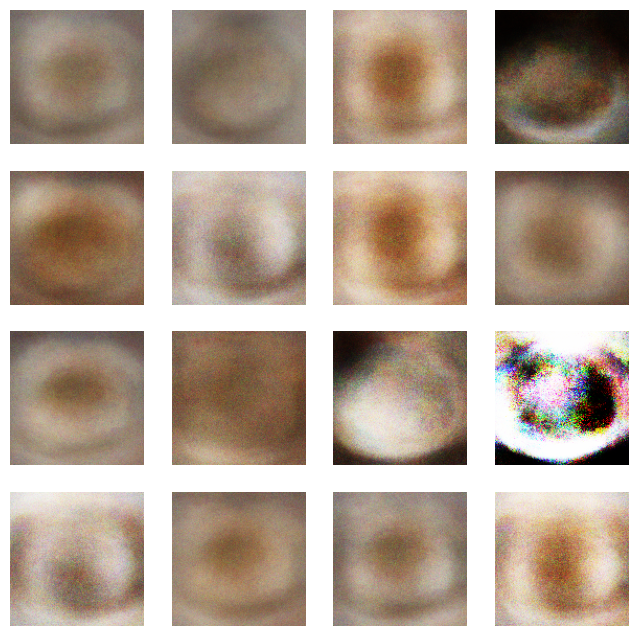

In [26]:
# Display generated images
show_generated_images(generator_base, latent_dim)

In [30]:
torch.save(generator_base.state_dict(), "saved_models/generator_base_epoch_50.pth")
torch.save(discriminator_base.state_dict(), "saved_models/discriminator_base_epoch_50.pth")


### Base Model - Evaluation

In [34]:
# Initialize the FID metric
fid_metric = FrechetInceptionDistance()

# Function to resize and normalize images to [0, 1] for FID
def preprocess_for_fid(images):
    images_resized = torch.stack([F.resize(img, (299, 299)) for img in images])
    return images_resized.clamp(0, 1)  # Ensure values are in the [0, 1] range

# Function to compute FID
def compute_fid(generator, dataloader, latent_dim, device, num_samples=5000, batch_size=64):
    generator.eval()
    fid_metric.to(device)

    # Add real images to FID metric
    for real_imgs in dataloader:
        real_imgs = real_imgs.to(device)
        real_imgs_resized = preprocess_for_fid(real_imgs)
        fid_metric.update(real_imgs_resized, is_real=True)

    # Generate fake images and add to FID metric
    with torch.no_grad():
        for _ in range(num_samples // batch_size):
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_imgs = generator(z)
            gen_imgs = (gen_imgs + 1) / 2  # Rescale [-1, 1] to [0, 1]
            gen_imgs_resized = preprocess_for_fid(gen_imgs)
            fid_metric.update(gen_imgs_resized, is_real=False)

    fid_score = fid_metric.compute()
    fid_metric.reset()
    generator.train()

    return fid_score.item()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\arshi/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:17<00:00, 6.27MB/s] 


In [36]:
# Evaluate FID
latent_dim = 100  # Ensure this matches your generator's latent dimension
num_samples = 1000  # Number of images to evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Calculating Fréchet Inception Distance...")
fid_score = compute_fid(generator_base, dataloader, latent_dim, device, num_samples=num_samples)
print(f"FID Score: {fid_score:.4f}")

Calculating Fréchet Inception Distance...
FID Score: 363.5993


In [43]:
import torch
from torch.nn.functional import softmax
from torchvision.models import inception_v3
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

# Function to preprocess images for InceptionV3
def preprocess_for_inception(images):
    images_resized = torch.stack([F.resize(img, (299, 299)) for img in images])
    images_normalized = (images_resized - 0.5) / 0.5  # Normalize to [-1, 1]
    return images_normalized

# Function to compute Inception Score
def compute_inception_score(generator, latent_dim, device, num_samples=5000, batch_size=64, splits=10):
    generator.eval()
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    preds = []
    with torch.no_grad():
        for _ in tqdm(range(num_samples // batch_size), desc="Generating Images for IS"):
            # Generate fake images
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_imgs = generator(z)
            gen_imgs = (gen_imgs + 1) / 2  # Rescale [-1, 1] to [0, 1]

            # Preprocess images for InceptionV3
            gen_imgs_preprocessed = preprocess_for_inception(gen_imgs).to(device)

            # Get predictions from InceptionV3
            logits = inception_model(gen_imgs_preprocessed)
            preds.append(softmax(logits, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)

    # Compute IS
    split_scores = []
    for i in range(splits):
        part = preds[i * (num_samples // splits): (i + 1) * (num_samples // splits), :]
        py = np.mean(part, axis=0)
        scores = part * (np.log(part) - np.log(py))
        split_scores.append(np.exp(np.mean(np.sum(scores, axis=1))))

    inception_score = np.mean(split_scores)
    std = np.std(split_scores)

    generator.train()
    return inception_score, std

# Evaluate Inception Score
latent_dim = 100  # Ensure this matches your generator's latent dimension
num_samples = 1000  # Number of images to evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Calculating Inception Score...")
inception_score, inception_std = compute_inception_score(generator_base, latent_dim, device, num_samples=num_samples)
print(f"Inception Score: {inception_score:.4f} ± {inception_std:.4f}")


Calculating Inception Score...


c:\Users\arshi\anaconda3\envs\yelp_image_models\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arshi\anaconda3\envs\yelp_image_models\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Generating Images for IS: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]

Inception Score: 2.1714 ± 0.1642


In [85]:
# Save FID and IS results
fid_score = compute_fid(generator_base, dataloader, latent_dim, device, num_samples=num_samples)
print(f"FID Score: {fid_score:.4f}")
with open("metrics.txt", "a") as f:
    f.write(f"FID Score Base Model: {fid_score:.4f}\n")

inception_score, inception_std = compute_inception_score(generator_base, latent_dim, device, num_samples=num_samples)
print(f"Inception Score: {inception_score:.4f} ± {inception_std:.4f}")
with open("metrics.txt", "a") as f:
    f.write(f"Inception Score Base Model: {inception_score:.4f} ± {inception_std:.4f}\n")


FID Score: 369.6523


c:\Users\arshi\anaconda3\envs\yelp_image_models\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arshi\anaconda3\envs\yelp_image_models\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Generating Images for IS: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s]

Inception Score: 2.1254 ± 0.0471


## Tuning 1

1. Adding Gradient penalty
2. Learning rate scheduler
3. Adding convolutional layers in generator and discriminator
4. Added batch normalization in disciminator

In [86]:
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        """
        Forward pass of the generator.
        z: Latent vector of shape (batch_size, latent_dim, 1, 1)
        """
        z = z.view(z.size(0), z.size(1), 1, 1)

        img = self.model(z)
        img = F.interpolate(img, size=(128, 128), mode='bilinear', align_corners=False)  # Resize to match real image size
        return img


In [87]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
        )
    
    def forward(self, img):
        """
        Forward pass of the discriminator.
        img: Input image of shape (batch_size, 3, 128, 128)
        """
        validity = self.model(img)
        return validity.view(-1)  # Flatten for scalar output


In [88]:
# Instantiate the models
latent_dim = 100  # Dimension of the noise vector (latent space)
generator1 = Generator(latent_dim).to(device)
discriminator1 = Discriminator().to(device)


In [89]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, device):
    """
    Computes the gradient penalty for WGAN-GP.
    """
    # Ensure sizes match
    if real_samples.size() != fake_samples.size():
        fake_samples = F.interpolate(fake_samples, size=real_samples.shape[2:], mode='bilinear', align_corners=False)

    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [90]:
def discriminator_loss(discriminator, real_images, fake_images, lambda_gp, device):
    """
    Calculates the discriminator loss with gradient penalty.
    """
    real_validity = discriminator(real_images)
    fake_validity = discriminator(fake_images.detach())
    gradient_penalty = compute_gradient_penalty(discriminator, real_images, fake_images, device)
    d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
    return d_loss


In [91]:
def generator_loss(discriminator, fake_images):
    """
    Calculates the generator loss.
    """
    g_loss = -torch.mean(discriminator(fake_images))
    return g_loss


In [92]:
# Hyperparameters
latent_dim = 100
batch_size = 64
lr = 1e-4
beta1, beta2 = 0.0, 0.9
lambda_gp = 10
n_epochs = 75

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate models
generator1 = Generator(latent_dim).to(device)
discriminator1 = Discriminator().to(device)

# Optimizers
g_optimizer = torch.optim.Adam(generator1.parameters(), lr=lr, betas=(beta1, beta2))
d_optimizer = torch.optim.Adam(discriminator1.parameters(), lr=lr, betas=(beta1, beta2))

# Scheduler
scheduler_g = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=20, gamma=0.5)
scheduler_d = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=20, gamma=0.5)


In [93]:
from tqdm import tqdm

for epoch in range(n_epochs):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        fake_images = generator1(z)

        # Update Discriminator
        d_optimizer.zero_grad()
        loss_D = discriminator_loss(discriminator1, real_images, fake_images, lambda_gp, device)
        loss_D.backward()
        d_optimizer.step()

        # Update Generator
        if i % 5 == 0:  # Update generator less frequently
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator1(z)
            loss_G = generator_loss(discriminator1, fake_images)
            loss_G.backward()
            g_optimizer.step()
    
    # Step learning rate scheduler
    scheduler_g.step()
    scheduler_d.step()

    # Print losses
    print(f"[Epoch {epoch + 1}/{n_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")


[Epoch 1/75] Loss_D: 0.8211 Loss_G: -0.0420
[Epoch 2/75] Loss_D: -0.0406 Loss_G: -0.1133
[Epoch 3/75] Loss_D: -0.0467 Loss_G: -0.1537
[Epoch 4/75] Loss_D: 0.1333 Loss_G: -0.1396
[Epoch 5/75] Loss_D: -0.0522 Loss_G: -0.1139
[Epoch 6/75] Loss_D: -0.0706 Loss_G: -0.1086
[Epoch 7/75] Loss_D: -0.0844 Loss_G: -0.1356
[Epoch 8/75] Loss_D: -0.0479 Loss_G: -0.0291
[Epoch 9/75] Loss_D: -0.0253 Loss_G: 0.0084
[Epoch 10/75] Loss_D: -0.0394 Loss_G: -0.0344
[Epoch 11/75] Loss_D: -0.0474 Loss_G: -0.0769
[Epoch 12/75] Loss_D: -0.1006 Loss_G: -0.0623
[Epoch 13/75] Loss_D: -0.0844 Loss_G: 0.0469
[Epoch 14/75] Loss_D: -0.1000 Loss_G: 0.0035
[Epoch 15/75] Loss_D: -0.0875 Loss_G: -0.0732
[Epoch 16/75] Loss_D: -0.0978 Loss_G: -0.1801
[Epoch 17/75] Loss_D: -0.0889 Loss_G: -0.0800
[Epoch 18/75] Loss_D: -0.0359 Loss_G: -0.1142
[Epoch 19/75] Loss_D: 0.0014 Loss_G: -0.1520
[Epoch 20/75] Loss_D: -0.0870 Loss_G: -0.1445
[Epoch 21/75] Loss_D: -0.1086 Loss_G: -0.0905
[Epoch 22/75] Loss_D: -0.1204 Loss_G: -0.0337
[Ep

In [94]:
# Function to visualize generated images
def visualize_generated_images(generator, latent_dim, num_images, device):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(num_images, latent_dim, 1, 1, device=device)
        # Generate fake images
        fake_images = generator(z)
        # Denormalize images if needed (assuming [-1, 1] range)
        fake_images = (fake_images + 1) / 2
        # Move images to CPU for visualization
        fake_images = fake_images.cpu()
    # Create a grid of images
    grid = vutils.make_grid(fake_images, nrow=int(num_images**0.5), padding=2, normalize=False)
    # Plot the grid
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(grid.permute(1, 2, 0))  # Convert from CHW to HWC for plotting
    plt.show()

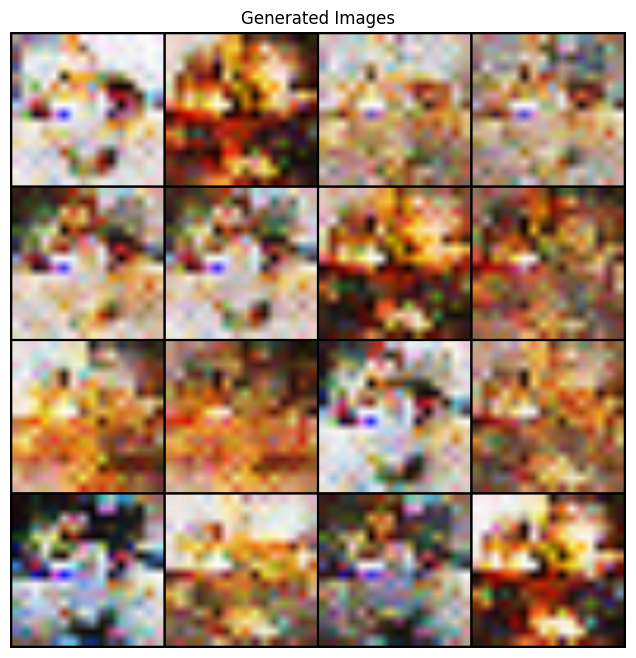

In [95]:
import torch.nn.functional as F

# Example usage
latent_dim = 100  # Set this to match your generator's latent dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_generated_images(generator1, latent_dim, num_images=16, device=device)

In [96]:
torch.save(generator1.state_dict(), "saved_models/generator_tuning1_epoch_75.pth")
torch.save(discriminator1.state_dict(), "saved_models/discriminator_tuning1_epoch_75.pth")


In [97]:
from torchvision.transforms.functional import resize

# Updated Preprocessing Function for FID
def preprocess_for_fid(images):
    images_resized = torch.stack([resize(img, (299, 299)) for img in images])
    images_normalized = images_resized.clamp(0, 1)  # Ensure range [0, 1]
    return images_normalized

# Updated Preprocessing Function for Inception
def preprocess_for_inception(images):
    images_resized = torch.stack([resize(img, (299, 299)) for img in images])
    images_normalized = (images_resized * 2) - 1  # Normalize to [-1, 1]
    return images_normalized


In [98]:
from torchvision.models import Inception_V3_Weights

inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False).to(device)


In [99]:
# Save FID and IS results
fid_score = compute_fid(generator1, dataloader, latent_dim, device, num_samples=num_samples)
print(f"FID Score: {fid_score:.4f}")
with open("metrics.txt", "a") as f:
    f.write(f"FID Score for Tuning 1: {fid_score:.4f}\n")

inception_score, inception_std = compute_inception_score(generator1, latent_dim, device, num_samples=num_samples)
print(f"Inception Score: {inception_score:.4f} ± {inception_std:.4f}")
with open("metrics.txt", "a") as f:
    f.write(f"Inception Score for Tuning 1: {inception_score:.4f} ± {inception_std:.4f}\n")


FID Score: 440.4061


Generating Images for IS: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s]

Inception Score: 1.4904 ± 0.0400
